This notebook contains code to compare SISTR (per-locus selection inference) vs. SISTR2 (joint estimation across loci)

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [1]:
%pylab inline
import glob
import numpy as np
import os

import sys
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Simulation_functions import *
from Joint_method_functions import *
from Per_locus_validation_functions import *

PLOTDIR = 'pdfs-round1'
PREFIX = 'Figure1d-'
SUPP_PREFIX = 'SuppFig4-'
RESFOLDER = '/gymreklab-tscc/bonnieh/joint_method/results_validation_top_x'

Populating the interactive namespace from numpy and matplotlib


In [3]:
def main(PLOTDIR, SUPP_PREFIX):
    
    means = [10**-5, 10**-4, 10**-3, 10**-2] 
    per_opt_combos = [(3,5),(2,11)] #(3,13),(2,20),(4,7),(4,10)
    folder = 'bin_agnostic_1000'
    range_list = [(0,1)] #(1,2)
    
    mut_params_dic = {}
    mut_params_dic[(3,5)] = 'Period 3 Optimal allele 5: Baseline mutation rate 10^-5.5' #, p=0.9, L=0.33'
    mut_params_dic[(3,13)] = 'Period 3 Optimal allele 13: Baseline mutation rate 10^-3' #, p=0.9, L=0.33'
    mut_params_dic[(2,11)] = 'Period 2 Optimal allele 11: Baseline mutation rate 10^-4.25' #, p=0.6, L=0.15'
    mut_params_dic[(2,20)] = 'mu=10^-3, p=0.6, L=0.15'
    mut_params_dic[(4,7)] = 'mu=10^-4.2, p=0.9, L=0.45'
    mut_params_dic[(4,10)] = 'mu=10^-3, p=0.9, L=0.45'
    
    # Per-locus Parameters
    model = 'eurodem_prior2'
    eps_het_numerator = 0.005
    eps_het_denominator =3
    eps_bins=0.3
    constant_common = 1
    denom_common = 1
    use_het = 'y'
    use_common = 'n'
    use_bins = 'y'
    num_bins = 5
    
    # Preprocess simulation lookup table
    # Get simulation tables
    sim_tables = {}
    ABC_tables = {}
    
    for per_opt_combo in per_opt_combos:

        file = '/gymreklab-tscc/bonnieh/abc/results/' + model + '/' + str(per_opt_combo[0]) + '_' + str(per_opt_combo[1]) + '.txt'  
        table = GetABCList(file, num_bins)
        dic_summ_stats = {}

        # Fill in dic_summ_stats: Key is s, value is list of (het, number of common alleles, bins) for given s value
        for combo in table:
            s_round = get_LRT_bin(combo[0])
            if s_round not in dic_summ_stats:
                dic_summ_stats[s_round] = []
            dic_summ_stats[s_round].append(combo[3]) # Append het, number of common alleles, bins for s value

        sim_tables[per_opt_combo] = dic_summ_stats

        # Preprocess ABC lookup table
        # Get ABC tables
        
        ABC_tables[per_opt_combo] = table
    
    for i in range(0,1):
        for combo in per_opt_combos:
            per = combo[0]
            opt = combo[1]
            
            for range_combo in range_list:
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharey=True, figsize = (12,4))
                a = 0.2
                if range_combo[0] == 1:
                    a = 0.3
                if range_combo[0] == 2:
                    a = 0.6
                fig.suptitle('%s '%(mut_params_dic[combo])) #(a = %.2f) 
                
                dic_ax = {}
                dic_ax[10**-5] = ax1
                dic_ax[10**-4] = ax2
                dic_ax[10**-3] = ax3
                dic_ax[10**-2] = ax4
                
                for mean in means:
                
                    plt1 = dic_ax[mean]
                    for j in range(range_combo[0],range_combo[1]):
                        
                        file_list = glob.glob('%s/%s/per_%d_opt_%d_*_%.8f.txt'%(RESFOLDER, folder, per, opt, mean)) 
                        file_list.sort()

                        filename = file_list[j]

                        allele_freqs_file = open(filename, 'r')
                        lines = allele_freqs_file.readlines()

                        # Line 6 is list of accepted medians
                        line = lines[6]       
                        info = line.strip().split(': ')
                        if len(info) > 1: 
                            params = info[1]
                            params = params.strip().split('), ')
                            params_list = []
                            list_of_med = [] 
                            for param in params:
                                param = param[1:]
                                if param[-1] == ')':
                                    param = param[:-1]
                                param = param.strip().split(', ')
                                params_list.append(((float(param[1])), float(param[2])))

                        #plt1.tick_params(axis="x", labelsize=12)
                        cum_dic = {}
                        for param in params_list:
                            s = [] # List of s values drawn from gamma distribution
                            num_sims = 1000
                            for i in range(0, num_sims):
                                s_val = np.random.gamma(param[0], param[1])
                                if s_val > 1: # 0.1
                                    s_val = 1

                                s.append(s_val)

                            
                            bins_list = [0]
                            exponents = [10**-5, 10**-4, 10**-3, 10**-2]
                            for j in exponents:
                                for i in np.arange(1,10,0.01):
                                    bins_list.append(i*j)

                            bins_list.append(0.1)
                            bins_list.append(1)
                            
                            values, base = np.histogram(s, bins=bins_list)
                            cumulative = list(np.cumsum(values))
                            maximum = max(cumulative)
                            cumulative_scaled = []
                            for elem in cumulative:
                                elem = elem/maximum
                                cumulative_scaled.append(elem)

                            cum_dic[param] = cumulative_scaled
                            base_plot = base

                        # Plot CDF
                        
                        count = 0
                        for elem in cum_dic:

                            if count == 0:
                                plt1.plot(base_plot[:-1], cum_dic[elem], label = 'Joint', color='blue', linewidth = 1, ls='dashed')
                            else:
                                plt1.plot(base_plot[:-1], cum_dic[elem], color='blue', linewidth = 1, ls='dashed')
                            count = count + 1
                      
                    # Get 20 per-locus CDFs
                    for c in range(0, 20):
                       
                        s_vals = []
                        
                        # Infer per-locus scores for 1000 loci
                        for i in range(0, 1000):

                            s = np.random.gamma(a, mean/a)

                            dic_summ_stats = sim_tables[combo] 
                            s_round = get_LRT_bin(s)

                            if s_round not in dic_summ_stats:
                                s_list_available = []
                                for elem in dic_summ_stats:
                                    s_list_available.append(elem)
                                s_round = getNearestS(s_round, s_list_available)

                            table = dic_summ_stats[s_round]
                            allele_freqs = random.choice(table)
                            freq_string = ','.join(str(round(item, 5)) for item in allele_freqs)

                            # Add 0s to allele frequency list if number of alleles less than number of bins
                            if len(allele_freqs) < num_bins:
                                num_zeros_to_add = int((num_bins - len(allele_freqs))/2)
                                for i in range(0, num_zeros_to_add):
                                    freq_string = '0.0,' + freq_string
                                    freq_string = freq_string + ',0.0'

                            # Get summary stats
                            obs_het, obs_common, obs_bins = GetSummStats(freq_string, num_bins)

                            # Read abcFile line by line and place in lookup table in the form of a list
                            abc_list = ABC_tables[combo]

                            # Perform ABC
                            s_ABC, lower_bound, upper_bound, num_accepted, s_accepted = Get_S_ABC(abc_list, 
                                                            obs_het, obs_common, obs_bins, eps_het_numerator, 
                                                            eps_het_denominator, constant_common, denom_common, eps_bins, use_het, 
                                                            use_common, use_bins)
                            if s_ABC > 0.1:
                                s_ABC = 0.1
                            s_vals.append(s_ABC)
                        
                        #bins_list = [0]
                        #exponents = [10**-5, 10**-4, 10**-3, 10**-2]
                        #for j in exponents:
                            #for i in np.arange(1,10,0.01):
                                #bins_list.append(i*j)

                        #bins_list.append(0.1)
                        #bins_list.append(1)
                        
                        values, base = np.histogram(s_vals, bins=bins_list)

                        cumulative = list(np.cumsum(values))
                        maximum = max(cumulative)
                        cumulative_scaled = []
                        for elem in cumulative:
                            elem = elem/maximum
                            cumulative_scaled.append(elem)

                        base_plot = base
                        if c == 0:
                            plt1.plot(base_plot[:-1], cumulative_scaled, label = 'Per-locus', color='red', linewidth = 1, ls='dashed')
                        else:
                            plt1.plot(base_plot[:-1], cumulative_scaled, color='red', linewidth = 1, ls='dashed')
                    
                    # Plot ground truth
                    s = [] # List of s values drawn from gamma distribution
                    num_sims = 1000
                    for i in range(0, num_sims):
                        s_val = np.random.gamma(a, mean/a)
                        if s_val > 0.1:
                            s_val = 0.1

                        s.append(s_val)
                    '''
                    bins_list = [0]
                    exponents = [10**-5, 10**-4, 10**-3, 10**-2]
                    for j in exponents:
                        for i in np.arange(1,10,0.01):
                            bins_list.append(i*j)

                    bins_list.append(0.1)
                    bins_list.append(1)
                    '''
                    values, base = np.histogram(s, bins=bins_list)

                    cumulative = list(np.cumsum(values))
                    maximum = max(cumulative)
                    cumulative_scaled = []
                    for elem in cumulative:
                        elem = elem/maximum
                        cumulative_scaled.append(elem)

                    base_plot = base
                    plt1.plot(base_plot[:-1], cumulative_scaled, label = 'Ground truth', color='black', linewidth = 3)
                    plt1.set_xlim(10**-5, 0.1)
                    plt1.set_xscale('log')
                    plt1.set_title('Mean s=' + str(mean)) 
                    #plt1.tick_params(axis="x", labelsize=12)
                        
                    print('Finished per %d opt %d mean '%(per,opt) + str(mean))
                
                # Add a big axis and hide frame
                plt.legend(bbox_to_anchor=(1, 1)) 
                fig.add_subplot(111, frameon=False)
                # Hide ticks and tick labels of the big axis
                plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                plt.xlabel('s')
                plt.ylabel('Cumulative Frequency')
                plt.savefig(os.path.join(PLOTDIR, SUPP_PREFIX + 'per_%d_opt_%d.pdf'%(per,opt)),bbox_inches='tight')  

Finished per 3 opt 5 mean 1e-05
Finished per 3 opt 5 mean 0.0001
Finished per 3 opt 5 mean 0.001
Finished per 3 opt 5 mean 0.01
Finished per 2 opt 11 mean 1e-05
Finished per 2 opt 11 mean 0.0001
Finished per 2 opt 11 mean 0.001
Finished per 2 opt 11 mean 0.01
CPU times: user 1h 1min 33s, sys: 438 ms, total: 1h 1min 34s
Wall time: 1h 1min 34s


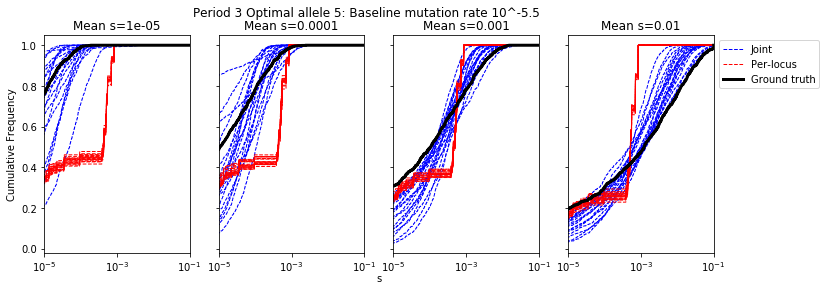

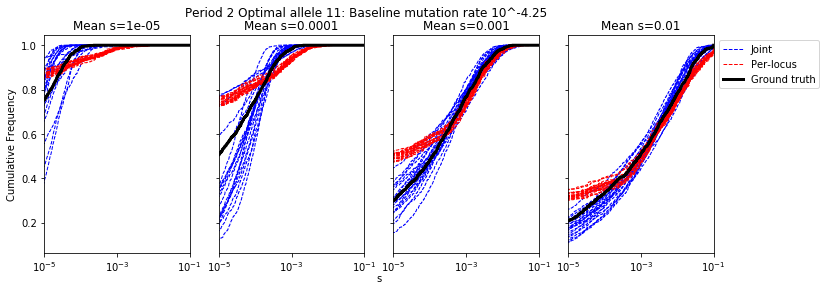

In [4]:
%%time
if __name__ == '__main__':
    main(PLOTDIR, SUPP_PREFIX)